# Fundamental Strat

In [40]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import nbformat
import datetime as dt
import scipy.stats as stats
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

In [65]:
# list low volume stocks
# https://finviz.com/screener.ashx?v=111&f=exch_nasd,geo_usa,ipodate_more15&o=volume
# if we were doing more, I would set up API, but this is only 10 stocks
stocks_list = ['SPY', 'INTG', 'HFBL', 'SFBC', 'AIRT', 'EEA', 'CSD', 'GBLI', 'NXN', 'PFIN', 'LINK']
securities = vbt.YFData.download(symbols=stocks_list)
sectors = securities.data.keys()
# create a new column for each sector
df = pd.DataFrame()
for sector in sectors:
    df[sector] = securities.data[sector]['Close']

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning: Symbols have mismatching index. Setting missing data points to NaN.
  data = cls.align_index(data, missing=missing_index)


In [67]:
df = df.dropna()

In [68]:
er = {}

In [75]:
# https://www.mlq.ai/capital-asset-pricing-model-python/
# interesting... https://github.com/omartinsky/FamaFrench/blob/master/famafrench.ipynb
def capm(stock):
    # create normalized prices for each stock
    df[f'{stock}_norm'] = df[stock] / df[stock].iloc[0]
    # create returns for each stock
    df[f'{stock}_ret'] = df[stock].pct_change()
    # set first row as 0
    df[f'{stock}_ret'].iloc[0] = 0
    # calculate beta of each stock
    X = np.array(df[f'{stock}_ret']).reshape(-1, 1)
    model = LinearRegression().fit(X, df['SPY_ret'])
    beta = model.coef_[0]
    beta, alpha = np.polyfit(df['SPY_ret'], df[f'{stock}_ret'], 1)
    print(beta)
    rm = df[f'{stock}_ret'].mean() * 252
    rf = 0.037
    er[stock] = rf + (beta * (rm-rf)) 

for stock in stocks_list:
    capm(stock)

1.0000000000000002
0.12280082479215569
0.07213266471027024
0.18355824062492382
0.4575010607580729
0.9419471810126541
0.9387275207733569
1.0095691878322044
0.07418349510032611
0.20074446492448292
0.19339470160668287


In [109]:
for column in df.columns:
    if column in er:
        df[f'{column}_rolling'] = df[column].rolling(10).mean() * 25.2
df=df.dropna()

In [115]:
for column in stocks_list:
    df.loc[df[f'{column}_rolling'] <= er[column], f'{column}_orders'] = 1
    df.loc[df[f'{column}_rolling'] > er[column], f'{column}_orders'] = -1

In [116]:
df.head()

,SPY,INTG,HFBL,SFBC,AIRT,EEA,CSD,GBLI,NXN,PFIN,...,CSD_rolling,CSD_orders,GBLI_rolling,GBLI_orders,NXN_rolling,NXN_orders,PFIN_rolling,PFIN_orders,LINK_rolling,LINK_orders
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-05 05:00:00+00:00,99.915039,18.049999,3.416524,7.448931,6.026968,6.033107,20.534878,33.356571,7.417066,5.842738,...,517.499929,-1,835.161154,-1,187.249394,-1,147.749132,-1,164.102400,-1
2008-02-06 05:00:00+00:00,99.110519,18.010000,3.416524,7.448931,6.199486,6.027333,20.334618,34.090782,7.438609,5.436286,...,518.845673,-1,838.230799,-1,187.303681,-1,146.511487,-1,160.876799,-1
2008-02-07 05:00:00+00:00,99.766006,18.010000,3.416524,7.448931,6.232876,6.004241,20.142702,34.674816,7.384749,5.893545,...,518.677449,-1,845.253195,-1,187.290115,-1,146.426135,-1,157.348799,-1
2008-02-08 05:00:00+00:00,99.125420,18.010000,3.416524,7.448931,6.288526,5.923413,20.217802,33.890545,7.357819,5.715722,...,519.665737,-1,851.350494,-1,187.276559,-1,145.999361,-1,153.417598,-1
2008-02-11 05:00:00+00:00,99.631958,18.010000,3.416524,7.489634,6.422089,5.963826,20.226143,32.972771,7.347041,6.071367,...,519.476485,-1,852.906345,-1,187.222269,-1,145.807312,-1,150.191997,-1


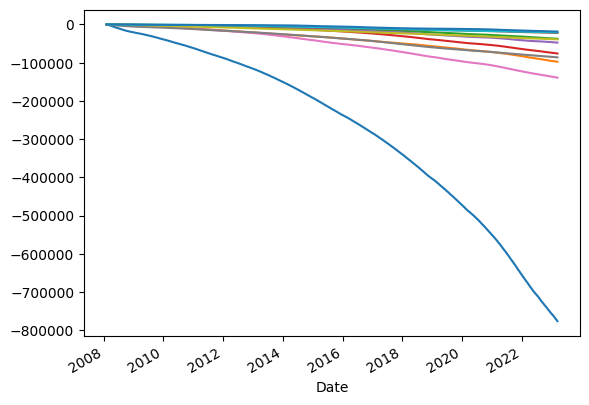

In [119]:
# calculate profits
for column in stocks_list:
    df[f'{column}_profit'] = df[column] * df[f'{column}_orders'].shift(1)

# calculate cumulative profits
for column in stocks_list:
    df[f'{column}_cumprofit'] = df[f'{column}_profit'].cumsum()

# calculate cumulative profits
for column in stocks_list:
    df[f'{column}_cumprofit'].plot()

In [120]:
close_df = df[stocks_list]
orders_df = df[[f'{stock}_orders' for stock in stocks_list]]
portfolio = vbt.Portfolio.from_orders(
    close_df[stocks_list[0]],
    orders_df[f'{stocks_list[0]}_orders'],
    cash_sharing=True,
)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 1d, C)
During: typing of argument at /Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/portfolio/nb.py (1369)

File "yja-env/lib/python3.9/site-packages/vectorbt/portfolio/nb.py", line 1369:
def simulate_from_orders_nb(target_shape: tp.Shape,
    <source elided>
    """
    check_group_lens_nb(group_lens, target_shape[1])
    ^


In [118]:
portfolio.stats()

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/Users/johnboesen/Documents/Code/#Algotraders/yja/yja-env/lib/python3.9/site-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2008-01-09 05:00:00+00:00
End                           2023-03-10 05:00:00+00:00
Period                                             3819
Start Value                                       100.0
End Value                                     386.55967
Total Return [%]                              286.55967
Benchmark Return [%]                         166.237722
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              51.448122
Max Drawdown Duration                             694.0
Total Trades                                          2
Total Closed Trades                                   0
Total Open Trades                                     2
Open Trade PnL                                286.55967
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 